In [263]:
import linsolve
import tf_linsolve
import scipy
import tensorflow as tf
import numpy as np
import pylab as plt
from copy import deepcopy
%load_ext line_profiler

from hera_cal import utils
from hera_cal.redcal import RedundantCalibrator, get_reds, make_sol_finite, calibrate_in_place, redundantly_calibrate
from hera_sim.antpos import hex_array
from hera_sim.vis import sim_red_data

from hera_cal.redcal import redcal_iteration

from tqdm import tqdm
import itertools

from uvtools.utils import FFT

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [264]:
def powerspectra(data, taper='blackman-harris'):
    """
    """
    return np.abs(FFT(data, taper=taper))

## Realistic Example

In [287]:
antpos = hex_array(4, split_core=False, outriggers=False)
reds = get_reds(antpos)
freqs = np.linspace(100e6, 200e6, 200)
true_gains, true_vis, data = sim_red_data(reds, shape=(20, 200))
data = {
    k: v.astype(np.complex64) + np.random.normal(0, 0.1, size=(20, 200)).astype(np.float32) + 1j * np.random.normal(0, 0.1, size=(20, 200)).astype(np.float32)
    for k, v in data.items()
}

/usr/local/anaconda3/lib/python3.8/site-packages/hera_sim/noise.py:204: UserWarning: white_noise is being deprecated. Use utils.gen_white_noise instead.
  warnings.warn("white_noise is being deprecated. Use utils.gen_white_noise instead.")


In [288]:
red_grp = [list(itertools.combinations(red, 2)) for red in reds]
red_grp = sum(red_grp, [])
max_grps = 25000
niter = len(red_grp) // max_grps + 1

In [94]:
Ngrps = 25000
Nfreqs = 200
Ntimes = 20
Nbits = 64

In [95]:
times_by_bl = {k[:2]: np.array([[2458092]]) for k in data.keys()}

In [96]:
#np.savez('hera_sim.npz', data=data, freqs=freqs, antpos=antpos)

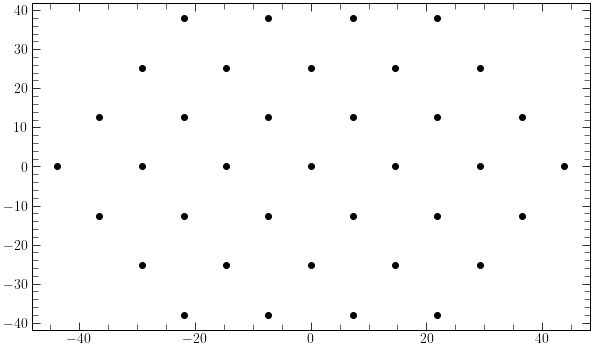

In [276]:
plt.figure(figsize=(10, 6))
for k, v in antpos.items():
    plt.scatter(v[0], v[1], color='k')
    
plt.show()

In [98]:
class DataObject:
    def __init__(self, data, freqs):
        self.freqs = freqs
        self.data = data
        
    def __getitem__(self, key):
        return self.data.get(key, 1)
    
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __iter__(self):
        return iter(self.data)
    
    def values(self):
        """
        """
        return self.data.values()
    
    def __len__(self):
        return len(self.data)
    
    def keys(self):
        """
        """
        return self.data.keys()
    
do = DataObject(data, freqs)

In [78]:
%%snakeviz -t
_ = redundantly_calibrate(do, reds, freqs, times_by_bl=times_by_bl)

UsageError: Cell magic `%%snakeviz` not found.


In [289]:
info_new = tf_linsolve.redcal.RedundantCalibrator(reds)
info = RedundantCalibrator(reds)
wgts = {k: np.random.uniform(0.8, 1, (20, 200)) for k in data.keys()}

In [290]:
def newrun(data, freqs, wgts):
    """
    """
    meta, sol0_new = info_new.firstcal(data, freqs, max_grps=100, min_vis_per_ant=None)
    meta, log_sol_new = info_new.logcal(data, sol0=sol0_new)
    meta, sol_new = info_new.omnical(data, log_sol_new, wgts=wgts, maxiter=500)
    return meta, sol0_new, log_sol_new, sol_new
    
def redcalrun(data, freqs, wgts):
    """
    """
    meta, sol0 = info.firstcal(data, freqs)
    meta, log_sol = info.logcal(data, sol0=sol0)
    meta, sol = info.omnical(data, log_sol, wgts=wgts, maxiter=500)

In [10]:
%%time
meta, sol0_new = info_new.firstcal(data, freqs, max_grps=1000)

CPU times: user 2.7 s, sys: 236 ms, total: 2.93 s
Wall time: 1.63 s


In [291]:
meta, sol0, log_sol, sol = newrun(data, freqs, wgts)

In [134]:
%lprun -f newrun newrun(data, freqs, wgts)

In [132]:
%lprun -f redcalrun redcalrun(data, freqs, wgts)

In [81]:
%%time
meta, sol0_new = info_new.firstcal(data, freqs, max_grps=100, min_vis_per_ant=None)
meta, log_sol_new = info_new.logcal(data, sol0=sol0_new)
meta, sol_new = info_new.omnical(data, log_sol_new, wgts=wgts, maxiter=500)

CPU times: user 3min 5s, sys: 6.54 s, total: 3min 11s
Wall time: 2min 57s


In [36]:
%%time
meta, sol0 = info.firstcal(data, freqs)
meta, log_sol = info.logcal(data, sol0=sol0)
meta, sol = info.omnical(data, log_sol, wgts=wgts, maxiter=500)

CPU times: user 32.1 s, sys: 606 ms, total: 32.7 s
Wall time: 30.2 s


In [37]:
%%time
meta, solb = info.firstcal(data, freqs)
meta, log_solb = info.logcal(data, sol0=solb)
meta, solab = info.omnical(data, log_solb, wgts=wgts, maxiter=500)

CPU times: user 32.8 s, sys: 648 ms, total: 33.4 s
Wall time: 31 s


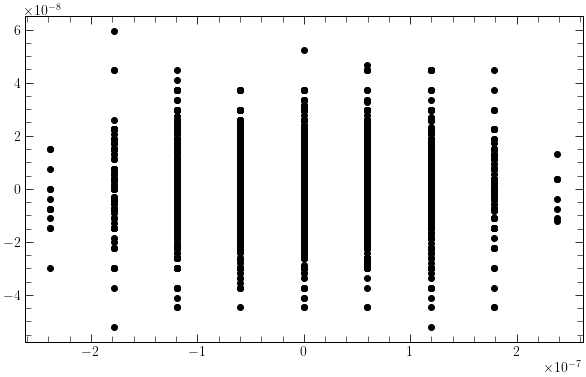

In [38]:
plt.figure(figsize=(10, 6))
for k in sol0_new.keys():
    if len(k) < 3:
        plt.scatter(
            sol[k][0].real - solab[k][0].real,
            sol[k][0].imag - solab[k][0].imag,
            color='k'
        )

#plt.xlim([-2e-7, 2e-7])
#plt.ylim([-2e-7, 2e-7])
plt.show()

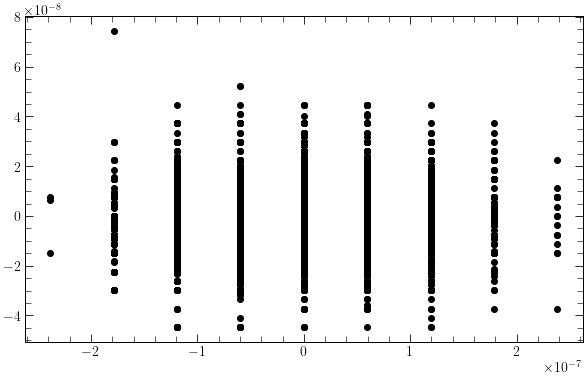

In [40]:
plt.figure(figsize=(10, 6))
for k in sol0_new.keys():
    if len(k) < 3:
        plt.scatter(
            sol[k][0].real - sol_new[k][0].real,
            sol[k][0].imag - sol_new[k][0].imag,
            color='k'
        )

#plt.xlim([-2e-7, 2e-7])
#plt.ylim([-2e-7, 2e-7])
plt.show()

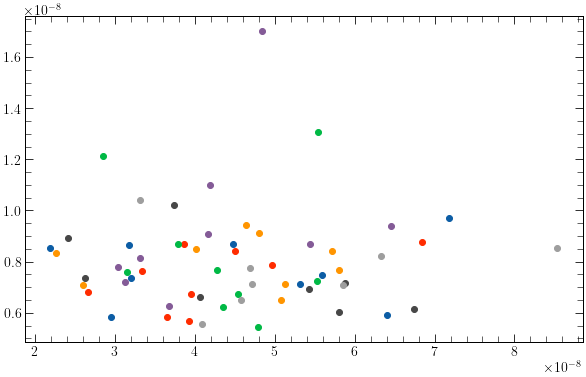

In [14]:
plt.figure(figsize=(10, 6))
for k in sol.keys():
    if len(k) < 3:
        plt.scatter(
            np.sqrt(np.mean(np.square(sol[k][0].real - sol_new[k][0].real))),
            np.sqrt(np.mean(np.square(sol[k][0].imag - sol_new[k][0].imag))),
        )

plt.show()

## Next

In [86]:
antpos = hex_array(11, split_core=True, outriggers=2)
reds = get_reds(antpos)

In [89]:
sum(map(lambda x: len(x) * (len(x) - 1) / 2, reds))

1857209.0

## IDX

In [83]:
from hera_cal.io import HERAData

In [95]:
def cal_org(data, reds):
    info = RedundantCalibrator(reds)
    meta, sol0 = info.firstcal(data, freqs)
    meta, sollog = info.logcal(data, sol0=sol0)
    wgts = {k: np.ones((1, 200)) for k in data.keys()}
    meta, sol = info.omnical(data, sollog, wgts=wgts, maxiter=500)
    return sol

In [96]:
%lprun -f cal_org cal_org(data, reds)

## New Omnical

In [327]:
OPTIMIZERS = {
    "Adadelta": tf.optimizers.Adadelta,
    "Adam": tf.optimizers.Adam,
    "Adamax": tf.optimizers.Adamax,
    "Ftrl": tf.optimizers.Ftrl,
    "Nadam": tf.optimizers.Nadam,
    "SGD": tf.optimizers.SGD,
    "RMSprop": tf.optimizers.RMSprop,
}


def data_model(g_r, g_i, vr, vi, ant0_inds, ant1_inds, vis_inds):
    """
    """
    gr0 = tf.gather(g_r, ant0_inds)
    gr1 = tf.gather(g_r, ant1_inds)
    gi0 = tf.gather(g_i, ant0_inds)
    gi1 = tf.gather(g_i, ant1_inds)
    vis_r = tf.gather(vr, vis_inds)
    vis_i = tf.gather(vi, vis_inds)
    grgr = gr0 * gr1
    gigi = gi0 * gi1
    grgi = gr0 * gi1
    gigr = gi0 * gr1
    model_r = (grgr + gigi) * vis_r + (grgi - gigr) * vis_i
    model_i = (gigr - grgi) * vis_r + (grgr + gigi) * vis_i
    return model_r, model_i


def mse(g_r, g_i, vr, vi, data_r, data_i, wgts, ants0_inds, ants1_inds, vis_inds):
    """
    """
    model_r, model_i = data_model(g_r, g_i, vr, vi, ants0_inds, ants1_inds, vis_inds)
    return tf.reduce_sum((tf.square(data_r - model_r) + tf.square(data_i - model_i)) * wgts)

def fit_gains(
    g_r,
    g_i,
    vr,
    vi,
    data_r,
    data_i,
    wgts,
    ants_ind0,
    ants_ind1,
    vis_ind,
    maxiter=1000,
    optimizer="Adamax",
    graph_mode=True,
    graph_args_dict={},
    **opt_kwargs,
):
    """
    """
    opt = OPTIMIZERS[optimizer](**opt_kwargs)
    g_r = tf.Variable(g_r)
    g_i = tf.Variable(g_i)
    vr = tf.Variable(vr)
    vi = tf.Variable(vi)
    vars = [g_r, g_i, vr, vi]

    def loss_function():
        """
        """
        return mse(g_r, g_i, vr, vi, data_r, data_i, wgts, ants_ind0, ants_ind1, vis_ind)

    def train_step_code():
        """
        """
        with tf.GradientTape() as tape:
            loss = loss_function()
        grads = tape.gradient(loss, vars)
        opt.apply_gradients(zip(grads, vars))
        return loss

    if graph_mode:

        @tf.function(**graph_args_dict)
        def train_step():
            return train_step_code()

    else:

        def train_step():
            return train_step_code()

    fit_history = {"loss": []}
    for step in tqdm(range(maxiter)):
        loss = train_step()
        fit_history["loss"].append(loss.numpy())

    return tf.complex(g_r, g_i).numpy(), tf.complex(vr, vi).numpy(), fit_history


def tensorize_components(data, wgts, reds, sol0):
    """
    """
    gt = list(filter(lambda x: len(x) < 3, list(sol0.keys())))
    gt = sorted([g[0] for g in gt])
    ants_map = {(g, 'Jnn'): gi for gi, g in enumerate(gt)}
    vis_map = {}
    ant_ind0, ant_ind1 = [], []
    vis_inds = []

    data_r, data_i = [], []
    wgts_arr = []
    g_r = [sol0[(g, "Jnn")].real for g in gt]
    g_i = [sol0[(g, "Jnn")].imag for g in gt]
    
    vr = []
    vi = []

    for ri, red in enumerate(reds):
        vis = sol0.get(red[0])
        if vis is None:
            vis = data[red[0]] / sol0[(red[0][0], 'Jnn')] / sol0[(red[0][1], 'Jnn')].conj()
        vr.append(vis.real)
        vi.append(vis.imag)
        vis_map[red[0]] = ri

    for key in data.keys():
        ant_ind0.append(ants_map[(key[0], 'Jnn')])
        ant_ind1.append(ants_map[(key[1], 'Jnn')])

        for ri, red in enumerate(reds):
            if key in red:
                vis_inds.append(ri)
                break

        data_r.append(data[key].real)
        data_i.append(data[key].imag)
        wgts_arr.append(wgts[key])
        
    g_r = tf.convert_to_tensor(g_r)
    g_i = tf.convert_to_tensor(g_i)
    data_r = tf.convert_to_tensor(data_r)
    data_i = tf.convert_to_tensor(data_i)
    vr = tf.convert_to_tensor(vr)
    vi = tf.convert_to_tensor(vi)
    wgts = tf.convert_to_tensor(wgts_arr, dtype=data_r.dtype)

    return g_r, g_i, vr, vi, data_r, data_i, wgts, ant_ind0, ant_ind1, vis_inds, ants_map, vis_map


def run_optimization(data, wgts, reds, sol0, maxiter=1000, graph_mode=False, optimizer='Adamax', graph_args_dict={}):
    """
    """
    (
        g_r,
        g_i,
        vr,
        vi,
        data_r,
        data_i,
        wgts,
        ant_ind0,
        ant_ind1,
        vis_ind,
        ants_map,
        vis_map
    ) = tensorize_components(data, wgts, reds, sol0)
    
    
    gains, vis, loss = fit_gains(
        g_r,
        g_i,
        vr,
        vi,
        data_r,
        data_i,
        wgts,
        ant_ind0,
        ant_ind1,
        vis_ind,
        maxiter=maxiter,
        graph_mode=graph_mode,
        optimizer=optimizer,
        graph_args_dict=graph_args_dict
    )
    sol = {g: gains[gi] for g, gi in ants_map.items()}
    sol.update({v: vis[vi] for v, vi in vis_map.items()})
    
    return sol, gains, vis, loss

In [318]:
tf_sol, gains, vis, loss = run_optimization(
    data,
    wgts,
    reds,
    log_sol,
    graph_mode=True,
    maxiter=1000,
    optimizer="Adamax",
    graph_args_dict={"jit_compile": True},
)

100%|██████████| 1000/1000 [01:22<00:00, 12.12it/s]


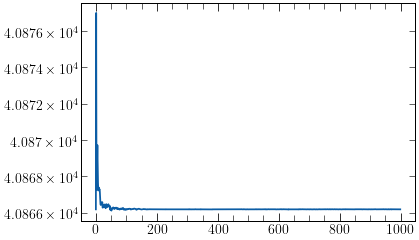

In [319]:
plt.semilogy(loss['loss'])

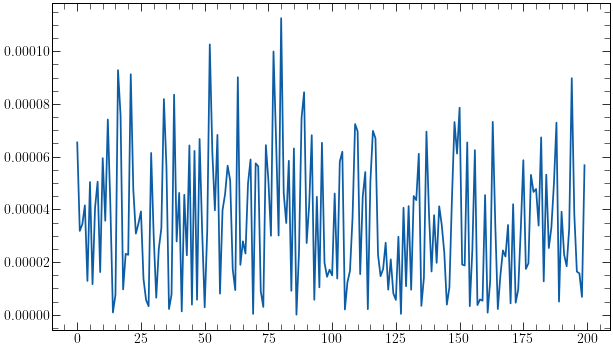

In [320]:
plt.figure(figsize=(10, 6))
#plt.plot(sol_new[(0, 'Jnn')][0].real - gains[0, 0].real)
plt.plot(np.abs(tf_sol[(0, 'Jnn')][0].real - sol[(0, 'Jnn')][0].real))
#plt.plot(sol_new[(0, 'Jnn')][0].imag - gains[0, 0].imag)
plt.show()

In [321]:
from hera_cal.redcal import reds_to_antpos
def remove_degen_gains(reds, gains, degen_gains=None, mode='phase'):
        """ Removes degeneracies from solutions (or replaces them with those in degen_sol).  This
        function in nominally intended for use with firstcal, which returns (phase/delay) solutions
        for antennas only.

        Args:
            gains: dictionary that contains gain solutions in the {(index,antpol): np.array} format.
            degen_gains: Optional dictionary in the same format as gains. Gain amplitudes and phases
                in degen_sol replace the values of sol in the degenerate subspace of redcal. If
                left as None, average gain amplitudes will be 1 and average phase terms will be 0.
                For logcal/lincal/omnical, putting firstcal solutions in here can help avoid structure
                associated with phase-wrapping issues.
            mode: 'phase' or 'complex', indicating whether the gains are passed as phases (e.g. delay
                or phi in e^(i*phi)), or as the complex number itself.  If 'phase', only phase degeneracies
                removed.  If 'complex', both phase and amplitude degeneracies are removed.
        Returns:
            new_gains: gains with degeneracy removal/replacement performed
        """

        # Check supported pol modes
        if degen_gains is None:
            if mode == 'phase':
                degen_gains = {key: np.zeros_like(val) for key, val in gains.items()}
            else:  # complex
                degen_gains = {key: np.ones_like(val) for key, val in gains.items()}
        ants = gains.keys()
        gainPols = np.array([ant[1] for ant in gains])  # gainPols is list of antpols, one per antenna
        antpols = list(set(gainPols))

        # Extract gain and model visibiltiy solutions
        gainSols = np.array([gains[ant] for ant in ants])
        degenGains = np.array([degen_gains[ant] for ant in ants])

        # Build matrices for projecting gain degeneracies
        antpos = reds_to_antpos(reds)
        positions = np.array([antpos[ant[0]] for ant in gains]) 
        Rgains = np.hstack((positions, np.ones((positions.shape[0], 1))))
        # Mgains is like (AtA)^-1 At in linear estimator formalism. It's a normalized estimator of degeneracies
        Mgains = np.linalg.pinv(Rgains.T.dot(Rgains)).dot(Rgains.T)

        # degenToRemove is the amount we need to move in the degenerate subspace
        if mode == 'phase':
            # Fix phase terms only
            degenToRemove = np.einsum('ij,jkl', Mgains, gainSols - degenGains)
            gainSols -= np.einsum('ij,jkl', Rgains, degenToRemove)
        else:  # working on complex data
            # Fix phase terms
            degenToRemove = np.einsum('ij,jkl', Mgains, np.angle(gainSols * np.conj(degenGains)))
            gainSols *= np.exp(np.complex64(-1j) * np.einsum('ij,jkl', Rgains, degenToRemove))
        
        new_gains = {ant: gainSol for ant, gainSol in zip(ants, gainSols)}
        return new_gains

In [322]:
tf_degen_free = remove_degen_gains(reds, true_gains, tf_sol, mode='complex')
degen_free = remove_degen_gains(reds, true_gains, sol, mode='complex')
degen_log = remove_degen_gains(reds, true_gains, log_sol, mode='complex')

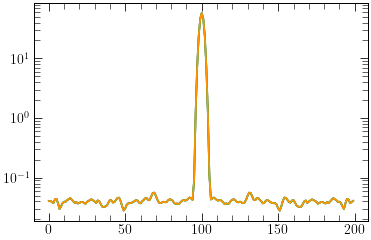

In [323]:
plt.semilogy(np.mean(powerspectra(tf_degen_free[(1, 'Jnn')], taper='bh7'), axis=0))
plt.semilogy(np.mean(powerspectra(degen_free[(1, 'Jnn')], taper='bh7'), axis=0))
plt.semilogy(np.mean(powerspectra(degen_log[(1, 'Jnn')], taper='bh7'), axis=0))

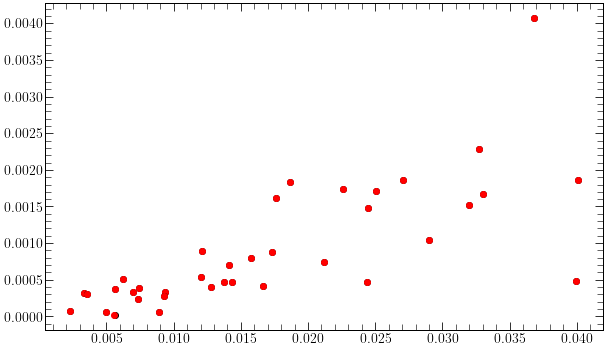

In [324]:
plt.figure(figsize=(10, 6))
tot_off = []
tot_off_real = []
for k in true_gains.keys():
    real = np.mean(np.abs(true_gains[k].real - tf_degen_free[k].real))
    imag = np.mean(np.abs(true_gains[k].imag - tf_degen_free[k].imag))
    tot_off.append((real, imag))
    plt.scatter(imag, real, color='k')
    
    real = np.mean(np.abs(true_gains[k].real - degen_free[k].real))
    imag = np.mean(np.abs(true_gains[k].imag - degen_free[k].imag))
    tot_off_real.append((real, imag))
    plt.scatter(imag, real, color='r')
    
plt.show()

In [325]:
np.mean(tot_off_real, axis=0)

array([0.00089878, 0.01714241])

In [326]:
np.mean(tot_off, axis=0)

array([0.00089877, 0.01714228])

## Steps to Calibrate

- Map data keys to antenna gain indices
- Map data keys to visibility indices
- 

sol0 = {
    (ant, "Jnn"): np.ones((1, freqs.shape[0])).astype("float32")
    + np.zeros((1, freqs.shape[0])).astype("float32") * 1j
    for ant in antpos
}

In [33]:
%%time
gains, model, fit_history = run_optimization(
    data, reds, tfsol0, maxiter=2000, graph_mode=True, optimizer="Adamax"
)

<ipython-input-30-c8e5f032d076>:103: ComplexWarning: Casting complex values to real discards the imaginary part
  g_r = [np.ones_like(sol0[(g, 'Jnn')]).astype(np.float32) for g in gt]
<ipython-input-30-c8e5f032d076>:104: ComplexWarning: Casting complex values to real discards the imaginary part
  g_i = [np.zeros_like(sol0[(g, 'Jnn')]).astype(np.float32) for g in gt]
100%|██████████| 2000/2000 [00:11<00:00, 179.38it/s]

CPU times: user 43.7 s, sys: 40.9 s, total: 1min 24s
Wall time: 11.3 s


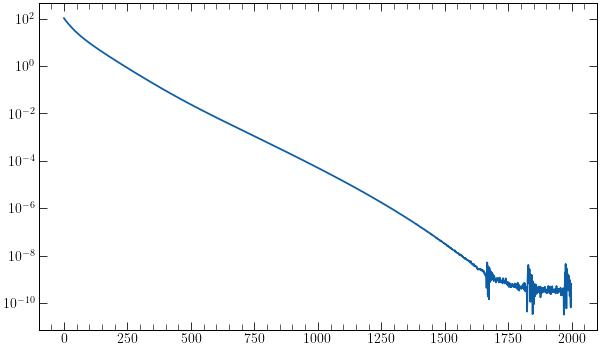

In [34]:
plt.figure(figsize=(10, 6))
plt.semilogy(np.abs(np.diff(fit_history['loss'])))
plt.show()

In [35]:
dict_gains = {(gi, 'Jnn'): np.array([gain]) for gi, gain in enumerate(gains)}


In [36]:
fixed_gains = info.remove_degen_gains(true_gains, dict_gains, mode='complex')
fixed_gains_other = info.remove_degen_gains(true_gains, sol, mode='complex')

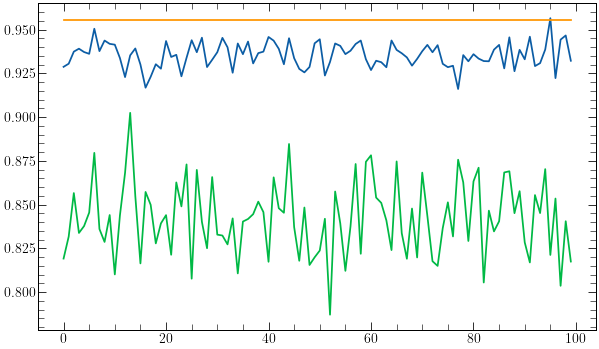

In [37]:
ant = 4
plt.figure(figsize=(10, 6))
plt.plot(fixed_gains[(ant, 'Jnn')][0].real)
plt.plot(fixed_gains_other[(ant, 'Jnn')][0].real)
plt.plot(true_gains[(ant, 'Jnn')][0].real)
plt.show()

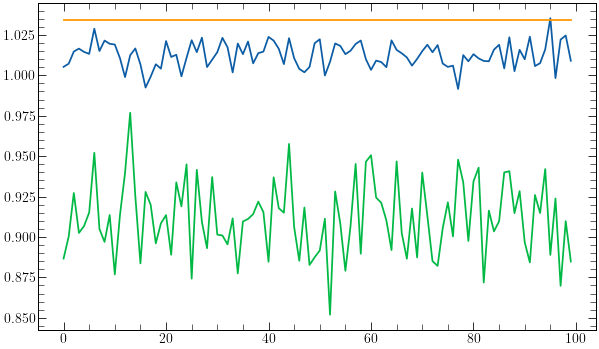

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(np.abs(fixed_gains[(0, 'Jnn')][0]))
plt.plot(np.abs(fixed_gains_other[(0, 'Jnn')][0]))
plt.plot(np.abs(true_gains[(0, 'Jnn')][0]))
plt.show()

## Firstcal

In [65]:
from hera_cal.datacontainer import DataContainer
from hera_cal.utils import split_bl

In [87]:
def _firstcal_iteration(self, data, df, f0, wgts={}, offsets_only=False, edge_cut=0,
                            sparse=False, mode='default', norm=True, medfilt=False, kernel=(1, 11)):
        '''Runs a single iteration of firstcal, which uses phase differences between nominally
        redundant meausrements to solve for delays and phase offsets that produce gains of the
        form: np.exp(2j * np.pi * delay * freqs + 1j * offset).
        Arguments:
            df: frequency change between data bins, scales returned delays by 1/df.
            f0: frequency of the first channel in the data
            offsets_only: only solve for phase offsets, dly_sol will be {}
            For all other arguments, see RedundantCalibrator.firstcal()
        Returns:
            dly_sol: dictionary of per-antenna delay solutions in the {(index,antpol): np.array}
                format.  All delays are multiplied by 1/df, so use that to set physical scale.
            off_sol: dictionary of per antenna phase offsets (in radians) in the same format.
        '''
        Nfreqs = data[next(iter(data))].shape[1]  # hardcode freq is axis 1 (time is axis 0)
        if len(wgts) == 0:
            wgts = {k: np.ones_like(data[k], dtype=np.float32) for k in data}
        wgts = DataContainer(wgts)
        taus_offs, twgts = {}, {}
        for bls in self.reds:
            for i, bl1 in enumerate(bls):
                d1, w1 = data[bl1], wgts[bl1]
                for bl2 in bls[i + 1:]:
                    d12 = d1 * np.conj(data[bl2])
                    if norm:
                        ad12 = np.abs(d12)
                        d12 /= np.where(ad12 == 0, np.float32(1), ad12)
                    w12 = w1 * wgts[bl2]
                    taus_offs[(bl1, bl2)] = utils.fft_dly(d12, df, f0=f0, wgts=w12, medfilt=medfilt,
                                                          kernel=kernel, edge_cut=edge_cut)
                    twgts[(bl1, bl2)] = np.sum(w12)
        d_ls, w_ls = {}, {}
        for (bl1, bl2), tau_off_ij in taus_offs.items():
            ai, aj = split_bl(bl1)
            am, an = split_bl(bl2)
            i, j, m, n = (self.pack_sol_key(k) for k in (ai, aj, am, an))
            eq_key = '%s-%s-%s+%s' % (i, j, m, n)
            d_ls[eq_key] = np.array(tau_off_ij)
            w_ls[eq_key] = twgts[(bl1, bl2)]
        ls = linsolve.LinearSolver(d_ls, wgts=w_ls, sparse=sparse)
        sol = ls.solve(mode=mode)
        dly_sol = {self.unpack_sol_key(k): v[0] for k, v in sol.items()}
        off_sol = {self.unpack_sol_key(k): v[1] for k, v in sol.items()}
        # add back in antennas in reds but not in the system of equations
        ants = set([ant for red in self.reds for bl in red for ant in utils.split_bl(bl)])
        dly_sol = {ant: dly_sol.get(ant, (np.zeros_like(list(dly_sol.values())[0]))) for ant in ants}
        off_sol = {ant: off_sol.get(ant, (np.zeros_like(list(off_sol.values())[0]))) for ant in ants}
        return dly_sol, off_sol

In [91]:
%%time
dly_sol, off_sol = _firstcal_iteration(info, data, df=np.diff(freqs)[0], f0=freqs[0])

CPU times: user 8.6 s, sys: 85.4 ms, total: 8.69 s
Wall time: 8.49 s


In [85]:
%%snakeviz -t
dly_sol, off_sol = _firstcal_iteration(info, data, df=np.diff(freqs)[0], f0=freqs[0])

 
*** Profile stats marshalled to file '/var/folders/kv/bmmfw089255d48342x5bshcw0000gn/T/tmp0yxpmww8'. 
Opening SnakeViz in a new tab...


In [73]:
from hera_cal.redcal import reds_to_antpos

In [107]:
def _firstcal_iteration(self, data, df, f0, wgts={}, offsets_only=False, edge_cut=0,
                            sparse=False, mode='default', norm=True, medfilt=False, kernel=(1, 11), min_vis_per_ant=None):
        '''Runs a single iteration of firstcal, which uses phase differences between nominally
        redundant meausrements to solve for delays and phase offsets that produce gains of the
        form: np.exp(2j * np.pi * delay * freqs + 1j * offset).
        Arguments:
            df: frequency change between data bins, scales returned delays by 1/df.
            f0: frequency of the first channel in the data
            offsets_only: only solve for phase offsets, dly_sol will be {}
            For all other arguments, see RedundantCalibrator.firstcal()
        Returns:
            dly_sol: dictionary of per-antenna delay solutions in the {(index,antpol): np.array}
                format.  All delays are multiplied by 1/df, so use that to set physical scale.
            off_sol: dictionary of per antenna phase offsets (in radians) in the same format.
        '''
        Nfreqs = data[next(iter(data))].shape[1]  # hardcode freq is axis 1 (time is axis 0)
        if len(wgts) == 0:
            wgts = {k: np.ones_like(data[k], dtype=np.float32) for k in data}
        wgts = DataContainer(wgts)
        taus_offs, twgts = {}, {}
        
        ndims = len(list(reds_to_antpos(self.reds).values())[0])
        reds_used = []
        ants = set([ant for red in self.reds for bl in red for ant in utils.split_bl(bl)])
        ants_used_count = {ant: 0 for ant in ants}
        
        for bls in self.reds:
            for i, bl1 in enumerate(bls):
                d1, w1 = data[bl1], wgts[bl1]
                for bl2 in bls[i + 1:]:
                    d12 = d1 * np.conj(data[bl2])
                    if norm:
                        ad12 = np.abs(d12)
                        d12 /= np.where(ad12 == 0, np.float32(1), ad12)
                    w12 = w1 * wgts[bl2]
                    taus_offs[(bl1, bl2)] = utils.fft_dly(d12, df, f0=f0, wgts=w12, medfilt=medfilt,
                                                          kernel=kernel, edge_cut=edge_cut)
                    twgts[(bl1, bl2)] = np.sum(w12)
                    
                    if not np.all(w12 == 0):
                        for bl_here in [bl1, bl2]:
                            for ant in utils.split_bl(bl_here):
                                ants_used_count[ant] += 1
                    
            if min_vis_per_ant is not None:
                reds_used.append(bls)
                
                if np.all(np.array(list(ants_used_count.values())) >= min_vis_per_ant):
                    ndims_here = len(list(reds_to_antpos(reds_used).values())[0])
                    if ndims_here == ndims:
                        break
                
            
        d_ls, w_ls = {}, {}
        for (bl1, bl2), tau_off_ij in taus_offs.items():
            ai, aj = split_bl(bl1)
            am, an = split_bl(bl2)
            i, j, m, n = (self.pack_sol_key(k) for k in (ai, aj, am, an))
            eq_key = '%s-%s-%s+%s' % (i, j, m, n)
            d_ls[eq_key] = np.array(tau_off_ij)
            w_ls[eq_key] = twgts[(bl1, bl2)]
        ls = linsolve.LinearSolver(d_ls, wgts=w_ls, sparse=sparse)
        sol = ls.solve(mode=mode)
        dly_sol = {self.unpack_sol_key(k): v[0] for k, v in sol.items()}
        off_sol = {self.unpack_sol_key(k): v[1] for k, v in sol.items()}
        # add back in antennas in reds but not in the system of equations
        dly_sol = {ant: dly_sol.get(ant, (np.zeros_like(list(dly_sol.values())[0]))) for ant in ants}
        off_sol = {ant: off_sol.get(ant, (np.zeros_like(list(off_sol.values())[0]))) for ant in ants}
        return dly_sol, off_sol

In [108]:
len(info.reds)

108

In [109]:
%%time
dly_sol1, off_sol1 = _firstcal_iteration(info, data, df=np.diff(freqs)[0], f0=freqs[0], min_vis_per_ant=10)

CPU times: user 1.22 s, sys: 291 ms, total: 1.51 s
Wall time: 1.53 s


In [110]:
for k in dly_sol1.keys():
    print (dly_sol[k] - dly_sol1[k])

[[-2.14547497e-17]]
[[-1.65774574e-17]]
[[6.29063304e-18]]
[[-1.20097605e-17]]
[[3.33534386e-17]]
[[-2.89659439e-18]]
[[2.09068556e-17]]
[[-3.2911365e-18]]
[[3.26868269e-17]]
[[-1.64592216e-17]]
[[2.15028439e-17]]
[[4.68652312e-17]]
[[1.2237453e-17]]
[[3.11255202e-17]]
[[-7.1611329e-18]]
[[-7.07119171e-18]]
[[3.05266846e-17]]
[[-5.05976984e-17]]
[[1.78753375e-17]]
[[-2.2233235e-18]]
[[2.85222741e-17]]
[[-1.10031308e-17]]
[[3.46101808e-18]]
[[5.68465625e-17]]
[[2.29699671e-17]]
[[-6.1836699e-17]]
[[-2.0833212e-17]]
[[1.63934327e-17]]
[[8.6312196e-18]]
[[-4.3194105e-17]]
[[5.20664297e-17]]
[[-3.48346249e-17]]
[[-4.30905037e-17]]
[[7.76100727e-19]]
[[1.97672685e-17]]
[[-2.20892498e-18]]
[[-3.41033883e-17]]
[[3.6021531e-18]]
[[2.81341832e-17]]
[[4.83049362e-17]]
[[9.87235109e-18]]
[[-5.71352372e-17]]
[[-6.24598344e-18]]
[[2.69974777e-17]]
[[2.21800643e-17]]
[[-1.14204407e-16]]
[[-4.95379263e-17]]
[[-4.29082991e-18]]
[[-3.04022492e-18]]
[[-1.61071031e-17]]
[[2.12450142e-17]]
[[-2.65660981e-

In [106]:
for k in off_sol.keys():
    print (off_sol[k] - off_sol1[k])

[[1.99540244e-08]]
[[1.80423668e-08]]
[[-1.87955234e-08]]
[[1.89284211e-08]]
[[-3.0367547e-08]]
[[-7.19636869e-09]]
[[-7.87007616e-09]]
[[-5.88127304e-09]]
[[-3.06172997e-08]]
[[2.58820825e-08]]
[[-2.4217257e-08]]
[[-4.95910449e-08]]
[[-1.11667152e-08]]
[[-3.57220429e-08]]
[[9.36944992e-09]]
[[1.18529401e-08]]
[[-2.62854407e-08]]
[[5.18013504e-08]]
[[-2.04023303e-08]]
[[-5.82622033e-09]]
[[-3.41727683e-08]]
[[1.23225935e-09]]
[[-8.80416458e-10]]
[[-3.7210036e-08]]
[[-2.31477546e-08]]
[[5.28505592e-08]]
[[2.1986018e-08]]
[[1.49090443e-09]]
[[-6.2694033e-09]]
[[4.06323977e-08]]
[[-5.27504e-08]]
[[3.58449921e-08]]
[[2.99924484e-08]]
[[-6.0034674e-09]]
[[-1.65011173e-08]]
[[-5.29277161e-09]]
[[3.40698602e-08]]
[[-7.09414571e-09]]
[[-1.9955513e-08]]
[[-5.14827552e-08]]
[[-6.78023143e-09]]
[[5.33545558e-08]]
[[1.00733435e-08]]
[[-2.46383233e-08]]
[[-1.36866643e-08]]
[[1.04413133e-07]]
[[4.0146829e-08]]
[[-3.08044943e-09]]
[[2.70637561e-09]]
[[2.11697835e-08]]
[[-1.8155898e-08]]
[[3.36570895e

## Comparing Redundant Solutions

In [70]:
%%time
meta, sol0 = info.firstcal(data, freqs)

CPU times: user 31.7 s, sys: 494 ms, total: 32.2 s
Wall time: 30.7 s


In [73]:
sols = []
for i in [1, 5, 10, 50, 100, 200, 500, None]:
    sols.append(info_new.firstcal(data, freqs, min_vis_per_ant=i)[1])

In [74]:
results_r = []
results_i = []
for i in range(8):
    rr = []
    ri = []
    for k in sols[i].keys():
        rr.append(np.sqrt(np.mean(np.square((sols[i][k].real - sol0[k].real) / sol0[k].real))))
        ri.append(np.sqrt(np.mean(np.square((sols[i][k].imag - sol0[k].imag) / sol0[k].real))))
        
    results_r.append(np.mean(rr))
    results_i.append(np.mean(ri))

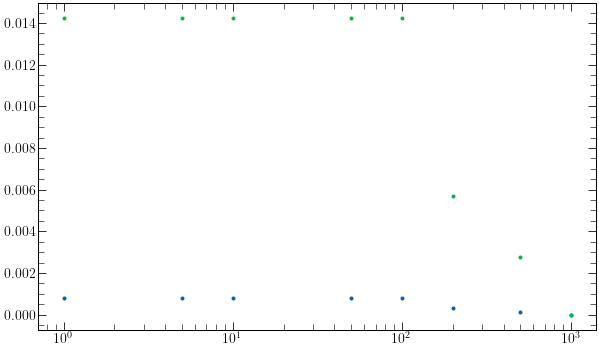

In [75]:
plt.figure(figsize=(10, 6))
plt.semilogx([1, 5, 10, 50, 100, 200, 500, 1000], np.array(results_r), '.')
plt.semilogx([1, 5, 10, 50, 100, 200, 500, 1000], np.array(results_i), '.')
plt.show()

In [81]:
%%time
_ = info_new.firstcal(data, freqs, min_vis_per_ant=200)

CPU times: user 7.33 s, sys: 989 ms, total: 8.32 s
Wall time: 6.77 s


In [ ]:
%%snakeviz -t
dly_sol, off_sol = _firstcal_iteration(info, data, df=np.diff(freqs)[0], f0=freqs[0])